# Beeler-Reuter AP Model

In this example we use the [1977 Beeler-Reuter model](http://scholarpedia.org/article/Models_of_cardiac_cell#Beeler-Reuter_model_.281977.29_.5B8_variables.5D) of the mammalian ventricular action potential [action potential](https://en.wikipedia.org/wiki/Action_potential), and try to estimate its maximum conductance parameters from its output.

The model describes several ion currents, each with a maximum conductance parameter, that together give rise to the cardiac AP and calcium transient. In this (non-trivial) "toy" model, we use the maximum conductances as parameters, and the AP and calcium transient as observable outputs. To make the problem tractable, all other model parameters are assumed to be known.

The parameters are _scaled_: instead of passing in the conductances directly, users provide the natural log of the maximum conductances. This makes the parameters easier to find for our optimisation algorithm.

For the science behind the model, see the [original 1977 paper](https://doi.org/10.1113/jphysiol.1977.sp011853).


In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

model = pints.toy.ActionPotentialModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
x0 = model.suggested_parameters()

And it can also provide a suggested sequence of sampling times:

In [3]:
times = model.suggested_times()

Using the suggested parameters and times, we can run a simulation:

In [4]:
values = model.simulate(x0, times)

This gives us all we need to create a plot of current versus time:

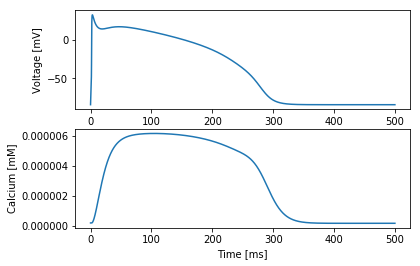

In [5]:
_, axes = plt.subplots(2, 1)
axes[0].plot(times, values[:, 0])
axes[1].plot(times, values[:, 1])
axes[0].set_ylabel('Voltage [mV]')
axes[1].set_ylabel('Calcium [mM]')
axes[1].set_xlabel('Time [ms]')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

In [6]:
# Add noise
values[:, 0] += np.random.normal(0, 1, values[:, 0].shape)
values[:, 1] += np.random.normal(0, 5e-7, values[:, 1].shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Add weighting to the outputs
# (we believe both outputs should contribute roughly equally to the score function
#  so we scale it with roughly the values that it spans)
weights = [1. / 70., 1. / 0.000006]

# Select a score function
score = pints.SumOfSquaresError(problem, weights=weights)

# Select some boundaries one order of magnitude above and below the suggested values
lower = [x - 2.0 for x in x0]
upper = [x + 2.0 for x in x0]
boundaries = pints.RectangularBoundaries(lower, upper)

# Perform an optimization with boundaries and hints
middle = [0.5 * (u + l) for l, u in zip(lower, upper)]
sigma = [(u - l) / 2. for l, u in zip(lower, upper)]
optimiser = pints.Optimisation(score, middle, sigma, boundaries, method=pints.CMAES)
optimiser.set_log_to_screen(False)

print('Running...')
found_parameters, found_score = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    # We take an exponential here to show the actual conductance values
    print(pints.strfloat(np.exp(x)) + '    ' + pints.strfloat(np.exp(x0[k])))

Running...
Found solution:          True parameters:
 3.98855003220894577e+00     4.00000000000000000e+00
 2.94727706551488767e-03     2.99999999999999920e-03
 8.86919145493889061e-02     8.99999999999999828e-02
 3.46365812264534778e-01     3.49999999999999922e-01
 7.88584425291200763e-01     8.00000000000000044e-01


We can better visualise the obtained results

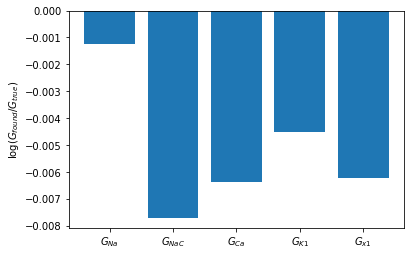

In [7]:
plt.figure()
logGRatio = (found_parameters - x0) / np.log(10)
x = range(len(logGRatio))
plt.bar(x, logGRatio)
plt.xticks(x, (r'$G_{Na}$', r'$G_{NaC}$', r'$G_{Ca}$', r'$G_{K1}$', r'$G_{x1}$'))
plt.ylabel(r'$\log(G_{found} / G_{true})$')
plt.show()

Note that the different are very small!

We can then compare the true and fitted model output

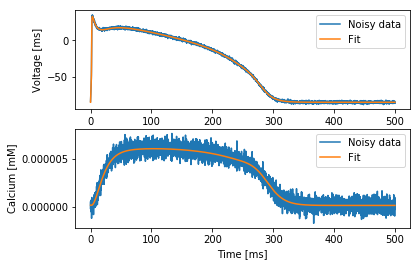

In [8]:
# Evaluate model at found parameters
found_values = problem.evaluate(found_parameters)

# Show quality of fit
_, axes = plt.subplots(2, 1)
axes[0].plot(times, values[:, 0], label='Noisy data')
axes[0].plot(times, found_values[:, 0], label='Fit')
axes[1].plot(times, values[:, 1], label='Noisy data')
axes[1].plot(times, found_values[:, 1], label='Fit')
axes[0].set_ylabel('Voltage [ms]')
axes[1].set_ylabel('Calcium [mM]')
axes[1].set_xlabel('Time [ms]')
axes[0].legend()
axes[1].legend()
plt.show()